In [69]:

from collections import defaultdict
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from torchmetrics.functional import peak_signal_noise_ratio as psnr
from torchmetrics.functional import structural_similarity_index_measure as ssim
from model import AttentionUNet

In [70]:
def load_model(checkpoint_path, encoder_name='resnet34'):
    model = AttentionUNet(encoder_name=encoder_name, pretrained=False)
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    return model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Calculate PSNR and SSIM
def calculate_metrics(output, ground_truth):
    psnr_value = psnr(output, ground_truth, data_range=1.0)
    ssim_value = ssim(output, ground_truth, data_range=1.0)
    return psnr_value.item(), ssim_value.item()

In [71]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((1024, 1024)),  # Resize the image to 1024x1024
    transforms.ToTensor(),             # Convert the image to a tensor
])

In [112]:
from pathlib import Path

# Set root_dir to the current working directory and move up to the parent folder if needed
root_dir = Path.cwd().parent  # Gets the parent of the current working directory

# Verify the directory path
print("Root directory:", root_dir)


Root directory: /home/div/Documents/phd_sem1/courses/project/DWDP_DLI_KLA


In [72]:


# Modify infer_and_evaluate to store metrics for each object
def infer_and_evaluate(model, input_folder, ground_truth_folder=None, mask_folder=None, save_output_folder="output_results_2"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    os.makedirs(save_output_folder, exist_ok=True)
    
    # Dictionary to store metrics for each object
    metrics = defaultdict(lambda: {'psnr': [], 'ssim': []})
    
    for filename in os.listdir(input_folder):
        object_name = filename.split('_')[0]  # Assuming object names are prefixes in filenames
        file_path = os.path.join(input_folder, filename)
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')) or not os.path.isfile(file_path):
            continue  # Skip non-image files

        # Load and pad the degraded image
        degraded_img = Image.open(file_path).convert("RGB")
        degraded_img_tensor = transform(degraded_img).unsqueeze(0).to(device)
        
        # Model inference
        with torch.no_grad():
            # output = model(degraded_img_tensor).squeeze().cpu()
            output = model(degraded_img_tensor).cpu()
        
        # Load ground truth if available
        if ground_truth_folder:
            ground_truth_img_path = os.path.join(ground_truth_folder, filename)
            if os.path.exists(ground_truth_img_path):
                ground_truth_img = Image.open(ground_truth_img_path).convert("RGB")
                ground_truth_tensor = transform(ground_truth_img).unsqueeze(0).to(device)
            
                # print(f"{ground_truth_tensor.shape=}", f"{output.shape=}")
                
                # Calculate PSNR and SSIM
                psnr_value, ssim_value = calculate_metrics(output, ground_truth_tensor)
                metrics[object_name]['psnr'].append(psnr_value)
                metrics[object_name]['ssim'].append(ssim_value)

    # Calculate average PSNR and SSIM per object and ssim_value_gt
    avg_psnr, avg_ssim = [], []
    object_names = sorted(metrics.keys())
    for obj in object_names:
        obj_psnr = np.mean(metrics[obj]['psnr'])
        obj_ssim = np.mean(metrics[obj]['ssim'])
        avg_psnr.append(obj_psnr)
        avg_ssim.append(obj_ssim)
        print(f"{obj} - Average PSNR: {obj_psnr:.2f}, Average SSIM: {obj_ssim:.4f}")

    # Calculate overall averages
    overall_psnr = np.mean(avg_psnr)
    overall_ssim = np.mean(avg_ssim)
    print(f"Overall Average PSNR: {overall_psnr:.2f}, Overall Average SSIM: {overall_ssim:.4f}")

    # Plot bar chart for PSNR and SSIM per object
    x = np.arange(len(object_names))
    plt.figure(figsize=(12, 6))
    
    # PSNR Plot
    plt.subplot(1, 2, 1)
    plt.bar(x, avg_psnr, color='skyblue')
    plt.xticks(x, object_names, rotation=45)
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR per Object')

    # SSIM Plot
    plt.subplot(1, 2, 2)
    plt.bar(x, avg_ssim, color='salmon')
    plt.xticks(x, object_names, rotation=45)
    plt.ylabel('SSIM')
    plt.title('SSIM per Object')

    plt.tight_layout()
    plt.show()


In [73]:

checkpoint_path = f"{root_dir}/Model/checkpoint_epoch_18.pth"
input_folder = f"{root_dir}/Dataset/structured_data/Val/degraded/"
ground_truth_folder = f"{root_dir}/Dataset/structured_data/Val/ground_truth/"  # Set to None if not available
mask_folder = f"{root_dir}/Dataset/structured_data/Val/defect_mask/"  # Include mask if available
save_output_folder = f"{root_dir}/test_results/"


/home/div/.virtualenvs/courses/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/home/div/.virtualenvs/courses/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


bottle - Average PSNR: 25.64, Average SSIM: 0.8233
cable - Average PSNR: 23.88, Average SSIM: 0.7696
capsule - Average PSNR: 27.92, Average SSIM: 0.8723
carpet - Average PSNR: 19.53, Average SSIM: 0.3980
grid - Average PSNR: 23.23, Average SSIM: 0.6259
hazelnut - Average PSNR: 28.79, Average SSIM: 0.8216
leather - Average PSNR: 25.36, Average SSIM: 0.6092
metal - Average PSNR: 26.12, Average SSIM: 0.7616
pill - Average PSNR: 27.22, Average SSIM: 0.8611
screw - Average PSNR: 28.46, Average SSIM: 0.8620
tile - Average PSNR: 23.48, Average SSIM: 0.6551
toothbrush - Average PSNR: 27.50, Average SSIM: 0.8161
transistor - Average PSNR: 26.56, Average SSIM: 0.8009
wood - Average PSNR: 24.54, Average SSIM: 0.5955
zipper - Average PSNR: 25.31, Average SSIM: 0.6425
Overall Average PSNR: 25.57, Overall Average SSIM: 0.7277


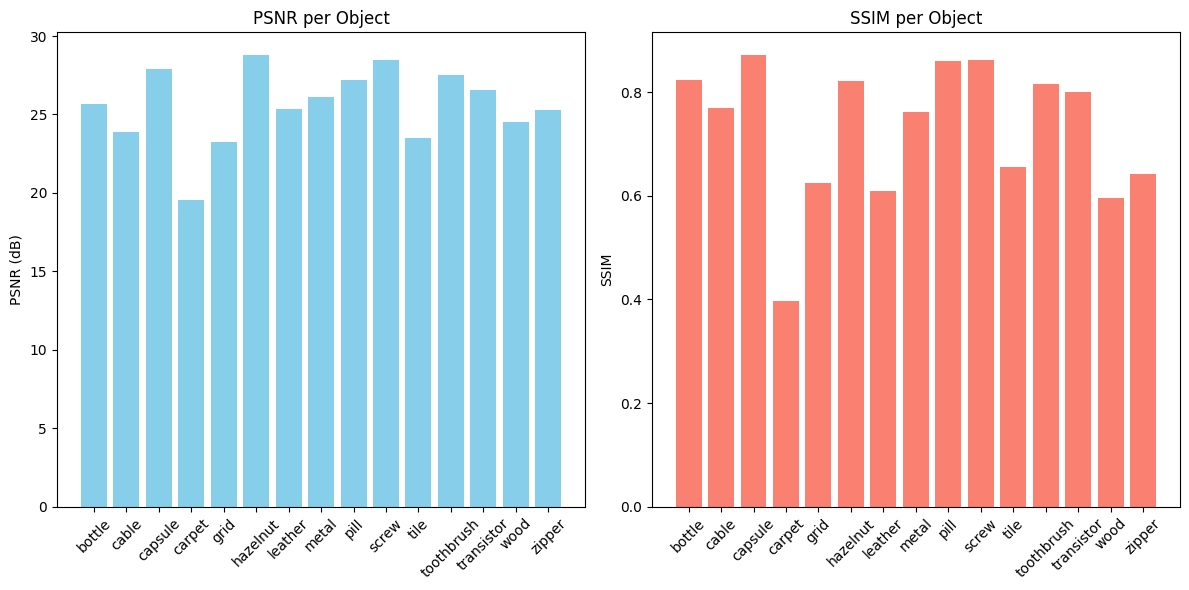

In [74]:



# Load the model
model = load_model(checkpoint_path)

# Perform inference and evaluation
metrics = infer_and_evaluate(model, input_folder, ground_truth_folder, save_output_folder=save_output_folder)

In [113]:
# Modify infer_and_evaluate to store metrics for each object
def infer_and_evaluate(model, input_folder, ground_truth_folder=None, mask_folder=None, save_output_folder="output_results_2"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    os.makedirs(save_output_folder, exist_ok=True)
    
    # Dictionary to store metrics for each object
    metrics = defaultdict(lambda: {'psnr_model_gt': [], 'ssim_model_gt': [], 'psnr_degraded_gt': [], 'ssim_degraded_gt': []})
    
    for filename in os.listdir(input_folder):
        object_name = filename.split('_')[0]  # Assuming object names are prefixes in filenames
        file_path = os.path.join(input_folder, filename)
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')) or not os.path.isfile(file_path):
            continue  # Skip non-image files

        # Load and process the degraded image
        degraded_img = Image.open(file_path).convert("RGB")
        degraded_img_tensor = transform(degraded_img).unsqueeze(0).to(device)
        
        # Model inference
        with torch.no_grad():
            output = model(degraded_img_tensor).cpu()
        # print(output.shape)
         # Save the output image
        output_img = (np.clip(output.squeeze().cpu().numpy(), a_min=0, a_max=1) * 255).astype(np.uint8)
        output_img = Image.fromarray(output_img.transpose(1, 2, 0))  # Ensure HWC format for RGB
        output_save_path = os.path.join(save_output_folder, f"output_{filename}")
        output_img.save(output_save_path)

       
        # Load ground truth if available
        if ground_truth_folder:
            ground_truth_img_path = os.path.join(ground_truth_folder, filename)
            if os.path.exists(ground_truth_img_path):
                ground_truth_img = Image.open(ground_truth_img_path).convert("RGB")
                ground_truth_tensor = transform(ground_truth_img).unsqueeze(0).to(device)
                
                # Calculate PSNR and SSIM for model output vs ground truth
                psnr_model_gt, ssim_model_gt = calculate_metrics(output, ground_truth_tensor)
                metrics[object_name]['psnr_model_gt'].append(psnr_model_gt)
                metrics[object_name]['ssim_model_gt'].append(ssim_model_gt)

                # Calculate PSNR and SSIM for degraded vs ground truth
                psnr_degraded_gt, ssim_degraded_gt = calculate_metrics(degraded_img_tensor, ground_truth_tensor)
                metrics[object_name]['psnr_degraded_gt'].append(psnr_degraded_gt)
                metrics[object_name]['ssim_degraded_gt'].append(ssim_degraded_gt)

    # Calculate average PSNR and SSIM per object for both degraded vs GT and model output vs GT
    avg_psnr_model_gt, avg_ssim_model_gt = [], []
    avg_psnr_degraded_gt, avg_ssim_degraded_gt = [], []
    object_names = sorted(metrics.keys())
    
    for obj in object_names:
        # Model output vs Ground Truth
        obj_psnr_model_gt = np.mean(metrics[obj]['psnr_model_gt'])
        obj_ssim_model_gt = np.mean(metrics[obj]['ssim_model_gt'])
        avg_psnr_model_gt.append(obj_psnr_model_gt)
        avg_ssim_model_gt.append(obj_ssim_model_gt)
        
        # Degraded vs Ground Truth
        obj_psnr_degraded_gt = np.mean(metrics[obj]['psnr_degraded_gt'])
        obj_ssim_degraded_gt = np.mean(metrics[obj]['ssim_degraded_gt'])
        avg_psnr_degraded_gt.append(obj_psnr_degraded_gt)
        avg_ssim_degraded_gt.append(obj_ssim_degraded_gt)
        
        # Print averages for each object
        print(f"{obj} - Avg PSNR (Model_pred vs GT): {obj_psnr_model_gt:.2f}, Avg SSIM (Model vs GT): {obj_ssim_model_gt:.4f}")
        print(f"{obj} - Avg PSNR (Degraded vs GT): {obj_psnr_degraded_gt:.2f}, Avg SSIM (Degraded vs GT): {obj_ssim_degraded_gt:.4f}")

    # Calculate overall averages
    overall_psnr_model_gt = np.mean(avg_psnr_model_gt)
    overall_ssim_model_gt = np.mean(avg_ssim_model_gt)
    overall_psnr_degraded_gt = np.mean(avg_psnr_degraded_gt)
    overall_ssim_degraded_gt = np.mean(avg_ssim_degraded_gt)
    
    # Print overall averages
    print(f"Overall Average PSNR (Model_pred vs GT): {overall_psnr_model_gt:.2f}, Overall Average SSIM (Model vs GT): {overall_ssim_model_gt:.4f}")
    print(f"Overall Average PSNR (Degraded vs GT): {overall_psnr_degraded_gt:.2f}, Overall Average SSIM (Degraded vs GT): {overall_ssim_degraded_gt:.4f}")

    # Plot bar charts for PSNR and SSIM per object
    x = np.arange(len(object_names))
    plt.figure(figsize=(14, 10))
    
    # PSNR Plot (Model vs GT)
    plt.subplot(2, 2, 1)
    plt.bar(x, avg_psnr_model_gt, color='skyblue')
    plt.xticks(x, object_names, rotation=45)
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR (Model_pred vs Ground Truth) per Object')

    # SSIM Plot (Model vs GT)
    plt.subplot(2, 2, 2)
    plt.bar(x, avg_ssim_model_gt, color='salmon')
    plt.xticks(x, object_names, rotation=45)
    plt.ylabel('SSIM')
    plt.title('SSIM (Model_pred vs Ground Truth) per Object')

    plt.subplot(2, 2, 3)
    plt.bar(x - 0.2, avg_psnr_model_gt, width=0.4, color='skyblue', label='Model_pred vs GT')
    plt.bar(x + 0.2, avg_psnr_degraded_gt, width=0.4, color='lightgreen', label='Degraded vs GT')
    plt.xticks(x, object_names, rotation=45)
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR per Object')
    plt.legend()

    # SSIM Plot (Model_pred vs GT and Degraded vs GT)
    plt.subplot(2, 2, 4)
    plt.bar(x - 0.2, avg_ssim_model_gt, width=0.4, color='salmon', label='Model_pred vs GT')
    plt.bar(x + 0.2, avg_ssim_degraded_gt, width=0.4, color='mediumseagreen', label='Degraded vs GT')
    plt.xticks(x, object_names, rotation=45)
    plt.ylabel('SSIM')
    plt.title('SSIM per Object')
    plt.legend()

    plt.tight_layout()
    plt.show()



In [116]:

checkpoint_path = f"{root_dir}/Model/checkpoint_epoch_18.pth"
input_folder = f"{root_dir}/Dataset/structured_data/Val/degraded/"
ground_truth_folder = f"{root_dir}/Dataset/structured_data/Val/ground_truth/"  # Set to None if not available
mask_folder = f"{root_dir}/Dataset/structured_data/Val/defect_mask/"  # Include mask if available
save_output_folder = f"{root_dir}/test_results/"


/home/div/.virtualenvs/courses/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `peak_signal_noise_ratio` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `peak_signal_noise_ratio` from `torchmetrics.image` instead.
  _future_warning(
/home/div/.virtualenvs/courses/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


bottle - Avg PSNR (Model_pred vs GT): 25.64, Avg SSIM (Model vs GT): 0.8233
bottle - Avg PSNR (Degraded vs GT): 15.37, Avg SSIM (Degraded vs GT): 0.0751
cable - Avg PSNR (Model_pred vs GT): 23.88, Avg SSIM (Model vs GT): 0.7696
cable - Avg PSNR (Degraded vs GT): 12.13, Avg SSIM (Degraded vs GT): 0.0238
capsule - Avg PSNR (Model_pred vs GT): 27.92, Avg SSIM (Model vs GT): 0.8723
capsule - Avg PSNR (Degraded vs GT): 16.54, Avg SSIM (Degraded vs GT): 0.0644
carpet - Avg PSNR (Model_pred vs GT): 19.53, Avg SSIM (Model vs GT): 0.3980
carpet - Avg PSNR (Degraded vs GT): 11.57, Avg SSIM (Degraded vs GT): 0.0432
grid - Avg PSNR (Model_pred vs GT): 23.23, Avg SSIM (Model vs GT): 0.6259
grid - Avg PSNR (Degraded vs GT): 11.52, Avg SSIM (Degraded vs GT): 0.0253
hazelnut - Avg PSNR (Model_pred vs GT): 28.79, Avg SSIM (Model vs GT): 0.8216
hazelnut - Avg PSNR (Degraded vs GT): 13.29, Avg SSIM (Degraded vs GT): 0.0239
leather - Avg PSNR (Model_pred vs GT): 25.36, Avg SSIM (Model vs GT): 0.6092
leath

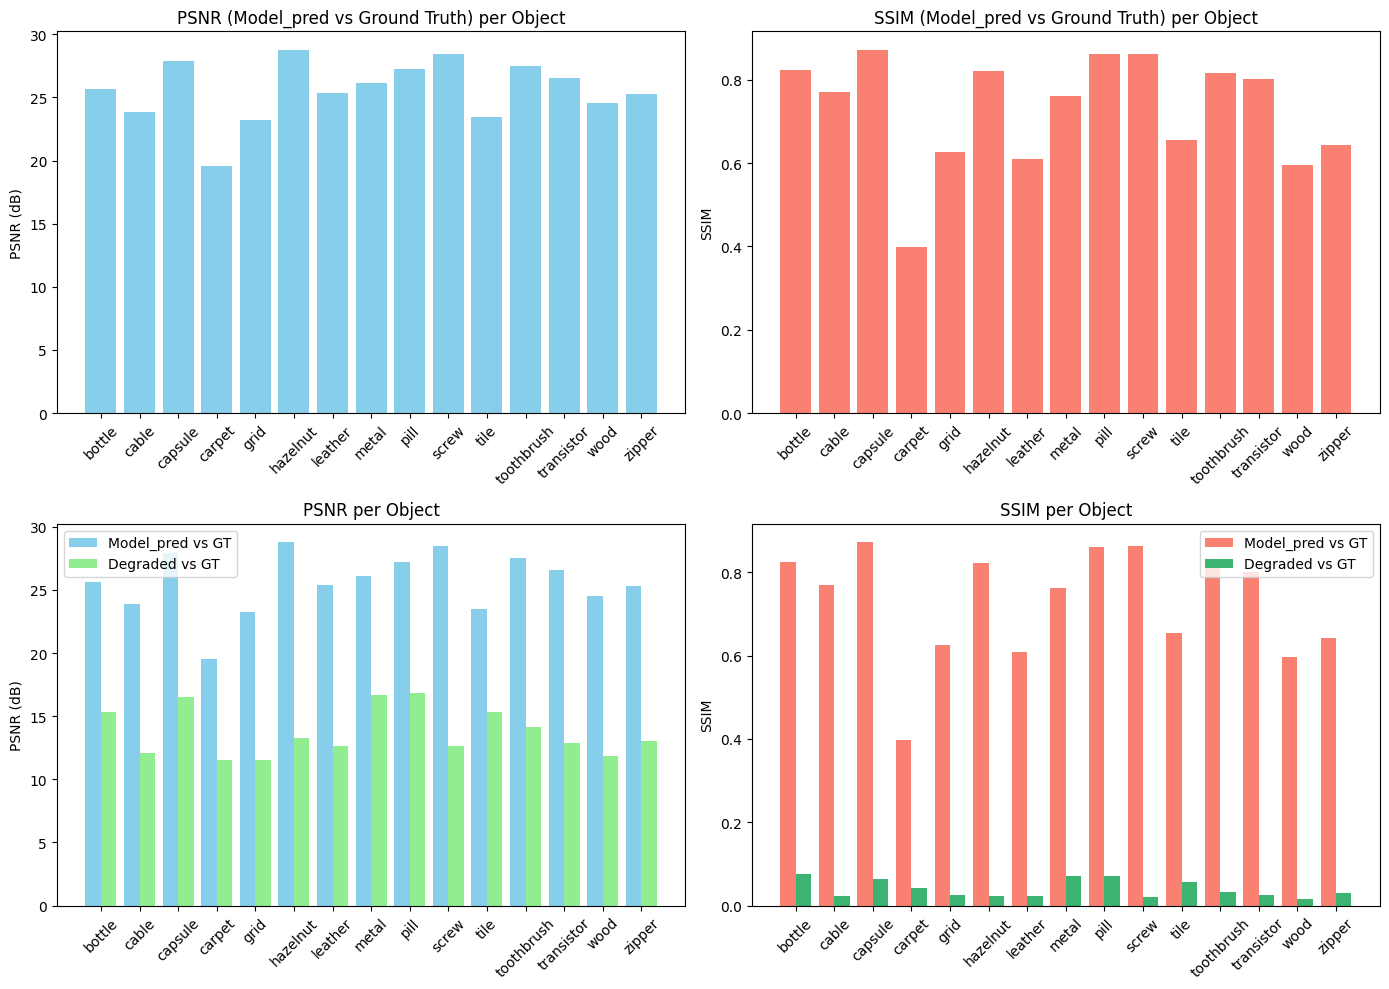

In [117]:



# Load the model
model = load_model(checkpoint_path)

# Perform inference and evaluation
metrics = infer_and_evaluate(model, input_folder, ground_truth_folder, save_output_folder=save_output_folder)